# Pregunta 1

## Funciones de activación

Primero, definimos las funciones de activación que puedan ser requeridas por el algoritmo

##### Softmax

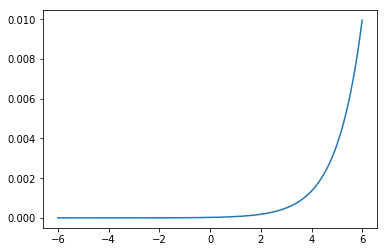

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def softmax(x):
    shiftx = x - np.max(x)
    exps = np.exp(shiftx)
    return exps / np.sum(exps)

testInput = np.arange(-6, 6, 0.01)
plt.plot(testInput, softmax(testInput))
plt.show()

Derivada Softmax

Referencia: https://stats.stackexchange.com/questions/153285/derivative-of-softmax-and-squared-error

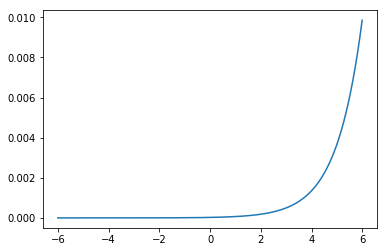

In [2]:
import numpy as np

# This is a mere approximation to the actual softmax prime
def softmax_prime(x):
    return softmax(x) * ( 1 - softmax(x))

testInput = np.arange(-6, 6, 0.01)
plt.plot(testInput, softmax_prime(testInput))
plt.show()

##### Sigmoid

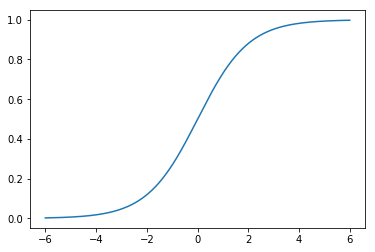

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1/(1+np.exp(-x))

testInput = np.arange(-6, 6, 0.01)
plt.plot(testInput, sigmoid(testInput))
plt.show()

Derivada sigmoid

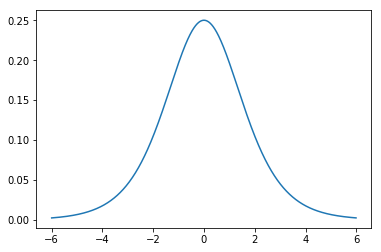

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid_prime(x):
    return np.exp(-x)/((1+np.exp(-x))**2)

testInput = np.arange(-6, 6, 0.01)
plt.plot(testInput, sigmoid_prime(testInput))
plt.show()

##### ReLu

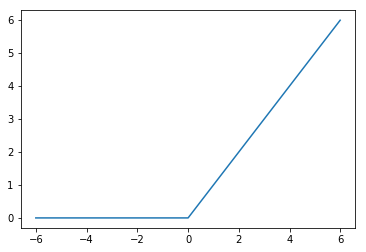

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def relu(x):
    return np.abs(x) * (x > 0)

testInput = np.arange(-6, 6, 0.01)
plt.plot(testInput, relu(testInput))
plt.show()

Derivada ReLU

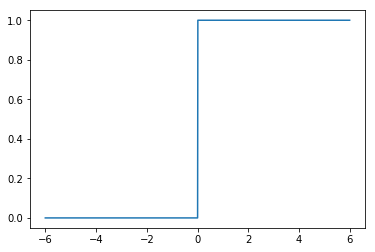

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def relu_prime(x):
    return np.where(x > 0, 1.0, 0.0)

testInput = np.arange(-6, 6, 0.01)
plt.plot(testInput, relu_prime(testInput))
plt.show()

##### Linear

In [7]:
def linear(x):
    return x

## Red neuronal feed-forward

Las ecuaciones requeridas por back propagation corresponden a:

1) $\delta^L = \nabla _a C \odot \sigma ' (z^L)$, con $\nabla_ a C = a^L - y$, donde se puede interpretar a $a^L$ como $\hat{y}$

2) $\delta^l = ((w^{(l + 1)})^T \delta^{(l+1)}) \odot \sigma ' (z^l)$

3) $\frac{\partial C}{\partial b^l_j} = \delta^l_ j$

4) $\frac{\partial C}{\partial w^l_{jk}} = a^{l-1}_k \delta^l_j$

Fuente: http://neuralnetworksanddeeplearning.com/chap2.html

In [8]:
import numpy as np
import warnings
from random import randint, random, seed, uniform, shuffle
import keras
from sklearn.metrics import accuracy_score

warnings.filterwarnings("ignore")
    
class Network:
    # The layers variable receives a specification with the following format:
    # [
    #    "neurons": n_neurones,
    #    "activation": "activation_function",
    # ]
    
    activation_function_hash = {
        "softmax": {
            "func": softmax,
            "func_prime": softmax_prime,
        },
        "sigmoid": {
            "func": sigmoid,
            "func_prime": sigmoid_prime,
        },
        
        "relu": {
            "func": relu,
            "func_prime": relu_prime,
        },
        
        "linear": {
            "func": linear,
            "func_prime": 1,
        }
    }
    
    # loss defines the method to calculate cost
    # crossentropy or mse
    def __init__(self, layers, loss="mse", mu = 1.0):
        self.layers = layers
        self.loss = loss
        self.loss_history = []
        self.mu = mu
        
        # The first layer is the input layer, and does not have biases
        # or weights
        self.biases = np.array([np.random.randn(l["neurons"], 1) for l in layers[1:]])
        
        # The amount of weights depensd on both the amount of neurones on the layer 
        # and the dimension of the inputs.
        self.weights = np.array([np.random.randn(curr_l["neurons"], prev_l["neurons"]) for prev_l, curr_l in zip(layers[:-1], layers[1:])])
        
        # self.biases = np.array([np.zeros((l["neurons"], 1)) for l in layers[1:]])
        # self.weights = np.array([np.zeros((curr_l["neurons"], prev_l["neurons"])) for prev_l, curr_l in zip(layers[:-1], layers[1:])])
        
    # Returns final output, activation output at each layer
    # and z value at each layer
    def forward_propagation(self, data):
        output = data
        activations = [data]
        zs = []
        
        # We start on the first layer. Note that the input layer
        # is pretty much ignored as it does not have activation
        # functions or anything like that.
        for B, W, layer, index in zip(self.biases, self.weights, self.layers, range(0, len(self.biases))):
            dot = np.dot(W, output)
            dot = dot.reshape(len(dot), 1)
            Z = dot + B

            zs.append(Z)
            activation_string = layer["activation"]
            g = Network.activation_function_hash[activation_string]["func"]
            output = g(Z)
            activations.append(output)

        return activations, zs    
    
    
    # Devuelve el output de la red
    def evaluate(self, X):
        output = []
        for x in X:
            (acts, zs) = self.forward_propagation(x)
            output.append(self.classify(acts[-1]))
            
        return np.array(output)
    
    def classify(self, x):
        chosen_class = 2 ** np.argmax(x)
        total_classes = self.layers[-1]["neurons"]
        return (((chosen_class & (1 << np.arange(total_classes)))) > 0).astype(int)
        
        
        
    
    # Receives a single sample X with its 
    # corresponding value Y and returns the 
    # derivatives for the weights and biases
    # We want to get dc/db and dc/dw
    
    def get_total_cost(self, X, Y):
        
        n = self.layers[-1]["neurons"]
        
        cost = 0.0
        A = self.evaluate(X)
        
        if self.loss == "mse":
            for a, y in zip(A, Y):
                cost += 0.5*np.linalg.norm((a.reshape(n, 1) - np.array(y).reshape(n, 1)))**2 / len(A)
        elif self.loss == "crossentropy":
            print("will calculate error", cost)
            for a, y in zip(A, Y):
                a = a.reshape(n, 1)
                y = np.array(y.reshape(n, 1))
                
                example_cost = -y * np.log(a) - (1 - y) * np.log(1 - a)
                print("example_cost", example_cost)
                
                cost += np.sum(np.nan_to_num(-y*np.log(a)-(1-y)*np.log(1-a))) / len(A)
        return cost

    def get_delta(self, a, z, y, activation_derivative):
        # Equation 1 says how this should got, at least for mse
        if self.loss == "mse":
            return (a - y) * activation_derivative(z)
        elif self.loss == "crossentropy":
            return (a - y)
        
        return None
    
    def backprop(self, x, y):
        # Initialize the gradient
        gradient_b = np.array([np.zeros(bias.shape) for bias in self.biases])
        gradient_w = np.array([np.zeros(weight.shape) for weight in self.weights])
        
        # Propagate the input through the network and get all the
        # z outputs and activation outputs of all layers
        # The first activation corresponds to the first input layer
        (acts, zs)  = self.forward_propagation(x)
        
        # Use the specified activation function's derivative
        activation_derivative = Network.activation_function_hash[self.layers[-1]["activation"]]["func_prime"]
        
        
        
        # We first calculate the delta value of the output layer, given as
        # delta_cost = aL - y
        # [ , , , , X] (= -1)
        # [ , , , X, ] ( = -2)
        # ....
        # [X, , , , ,] ( = -L)
        n = self.layers[-1]["neurons"]

        delta = self.get_delta(acts[-1].reshape(n, 1), zs[-1].reshape(n, 1), y.reshape(n, 1), activation_derivative)
        # 
        # Gradient B = delta
        gradient_b[-1] = delta
        
        # Gradient W = delta x A(L - 1)T
        gradient_w[-1] = np.dot(delta, acts[-2].T)

        # We now have the L layer with its deltas and gradients claculated.
        # Now we iterate over each layer to get the specific deltas
        for l in range(2, len(self.layers)):
            
            # Use the specified activation function's derivative
            activation_derivative = Network.activation_function_hash[self.layers[-l]["activation"]]["func_prime"]

            delta = np.dot(self.weights[-l + 1].T, delta) * activation_derivative(zs[-l])
            
            gradient_b[-l] = delta
            
            if (l == len(self.layers) - 1):
                
                dim = len(acts[-l - 1])
                
                gradient_w[-l] = np.dot(delta, np.array(acts[-l - 1]).reshape(dim, 1).T)
            else:
                gradient_w[-l] = np.dot(delta, acts[-l - 1].T)
            
        return (gradient_b, gradient_w)
            
    def get_costs(self):
        return self.loss_history
        
    def SGD(self, trainX, trainY, epochs, learn_rate):
        
        change_b = np.array([np.zeros(b.shape) for b in self.biases])
        change_w = np.array([np.zeros(w.shape) for w in self.weights])
    
        for epoch in range(0, epochs):
            np.random.shuffle(trainX)
        
            for X, Y in zip(trainX, trainY):

                """
                The backprop function will propagate the current information
                through the network and then calculate the gradients of
                each layer. Considering that we have a single bias per layer,
                gradient_b will be an array of size L, being L the total number
                of layers, excluding the input layer.

                gradient_w will be an array of size L too, in which each element
                becomes a vector that represents the gradient of all the weights
                of a layer.
                """
                (gradient_b, gradient_w) = self.backprop(X, Y)

                """
                Now that we have the gradients of the weights, we want to
                store this information for this particular training example in
                order to average it later on. The change_b represents the sum of
                the changes of all training examples for all biases, and change_w
                does the same for all weights.

                Later, as if we were trying to get the average of a list, we will
                divide this sum by the total amount of examples. This will tell
                us the average change of all training examples and allow us to
                modify the weights.
                """
                
                for cb in change_b:
                    if(np.isinf(cb).any()):
                        print("Invalid change_b", epoch, cb)
                        raise ValueError('Unhealthy network')
                    
                for cw in change_w:
                    if(np.isinf(cw).any()):
                        print("Invalid change_w", epoch, cw)
                        raise ValueError('Unhealthy network')
                      
                    
                for gb in gradient_b:
                    if(np.isinf(gb).any()):
                        print("Invalid gradient_b", epoch, gb)
                        raise ValueError('Unhealthy network')

                for gw in gradient_w:
                    if(np.isinf(gw).any()):
                        print("Invalid gradient_w", epoch, gw)
                        raise ValueError('Unhealthy network')
                
                change_b = [(cb + gb)
                            for cb, gb in zip(change_b, gradient_b)]
                change_w = [(cw + gw)
                            for cw, gw in zip(change_w, gradient_w)]


            self.weights = [weight - (learn_rate / len(trainX)) * weight_change for weight, weight_change in zip(self.weights, change_w)]
            self.biases = [bias -(learn_rate / len(trainX)) * bias_change for bias, bias_change in zip(self.biases, change_b)]  
            
            # Look for unhealthy values
            
            
            for layer_biases, layer_weights in zip(self.biases, self.weights):
                for weight in layer_weights:
                    if (np.isinf(weight).any() or np.isnan(weight).any()):
                        print("Infinity detected in weight", weight, layer_weights, gradient_w, change_w)
                        raise ValueError('Unhealthy network')
                for bias in layer_biases:
                    if (np.isinf(bias) or np.isnan(bias)):
                        print("Infinity detected in bias", bias, layer_biases)
                        raise ValueError('Unhealthy network')
                        
            #print("Epoch", epoch + 1)
            #print("Biases in last layer", self.biases[-1])
            #print("Weights in last layer", self.weights[-1])
                
            
            cost = self.get_total_cost(trainX, trainY)
            # print("Epoch", epoch + 1, "(", cost,")")
            # Save the loss function on each epoch for future experiments
            self.loss_history.append(cost)
                
    
# The network should have 2 layers, the first with 32 neurons and the second with 16
# You basically will have an architecture like this:
# input -> layer 1 (32) -> later 2 (16) -> output (3 neurons with softmax activation function)

"""
Bellow here we test our implementation
"""
import keras
seed(10)
T = 100
M = 5
dataX = np.array([np.random.randn(M, 1) for n in range(0, T)])
dataY = [randint(0,2) for n in range(0, T)]
dataYOnehot = keras.utils.to_categorical(dataY)
network = Network([{
    "neurons": M,
    "activation": "linear"
}, {
    "neurons": 32,
    "activation": "sigmoid"
}, {
    "neurons": 16,
    "activation": "sigmoid"
}, {
    "neurons": 3,
    "activation": "softmax"
}])

x = dataX[0]
y = dataY[0]


network.SGD(dataX, dataYOnehot, 300, 0.1)
yHat = np.array(network.evaluate(dataX))

# Measure accuracy

from sklearn.metrics import accuracy_score
print("Tests passed with a score of: ", accuracy_score(dataYOnehot, yHat))








Using TensorFlow backend.
/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Tests passed with a score of:  0.33


## Función de evaluación y categorización

La función que permite evaluar un vector de datos particulares está implementada en la clase de la red neuronal previamente utilizada, bajo el nombre `evaluate`. De forma análoga, la función para clasificar está también dentro de la red bajo el nombre de `classify`

## Validación del algoritmo

En esta sección, se genera el dataset iris y se definen funciones que permitirán evaluar fácilmente la red neuronal.

##### Generación del dataset

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
X_train,y_train = load_iris(return_X_y=True)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

# Convert the targets to one hot vectors
import keras
y_onehot = keras.utils.to_categorical(y_train)

##### Entrenamiento, clasificación y error

Definimos una función que nos permitirá probar nuestra red neuronal en pocas lineas de código, ajustando distintos parámetros.

In [10]:
from sklearn.metrics import accuracy_score
# Funcion que recibe parametros de la red y que retorna el error de entrenamiento
# X:               Vector de datos de prueba
# y:               Output de datos de prueba numérico
# activations:     Lista con las activaciones requeridas. Debe ser un total de
#                  4 y se permite: linear, sigmoid, softmax, relu.
# epochs:          Número de iteraciones
# learning_rate:   Learning rate
def evaluate_network_with_parameters(X, y, activations, epochs, learning_rate, loss="mse"):
    # Entrenamos primero nuestra red neuronal
    M = len(X[0])
    
    network = Network([{
        "neurons": M,
        "activation": "linear",
    }, {
        "neurons": 32,
        "activation": activations[0]
    }, {
        "neurons": 16,
        "activation": activations[1]
    }, {
        "neurons": 3,
        "activation": activations[2]
    }], loss=loss)
    network.SGD(X, y, epochs, learning_rate)

    # El resultado es el siguiente
    result = network.evaluate(X)
    
    return accuracy_score(y_onehot, result)


##### Experimentos

A continuación se realizan pruebas con distintas funciones de activación en la capa intermedia

In [13]:
import numpy as np
from timeit import default_timer as timer
# Definición del número de epochs a probar
epochs = np.arange(10, 1000, 50)

X = X_train
y = y_onehot

results = {
    "mse": {
        "sigmoid_sigmoid": {},
        "relu_relu": {},
    },
    "crossentropy" : {
        "sigmoid_sigmoid": {},
        "relu_relu": {},
    }
}

for loss in results:
    for activation_string in results[loss]:
        layers = activation_string.split("_")
        layers.append("softmax")
        
        results[loss][activation_string]["results"] = []
        results[loss][activation_string]["exec_time"] = []
        
        print("Evaluating", loss, layers[0], layers[1])
        for n in epochs:
            start = timer()
            accuracy = evaluate_network_with_parameters(X, y, layers, n, 0.1, loss="mse")
            end = timer()
            results[loss][activation_string]["results"].append(accuracy)
            results[loss][activation_string]["exec_time"].append(end - start)


Evaluating mse sigmoid sigmoid
Infinity detected in weight [nan nan nan nan] [[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]] [array([[-3.94482522e-13,  2.49840147e-13, -3.29814040e-13,
        -4.09707804e-13],
       [-1.40699386e-12,  8.91100448e-13, -1.17634192e-12,
        -1.46129760e-12],
       [ 5.02093889e-12, -3.17994345e-12,  4.19784413e-12,
         5.21472495e-12],
       [-3.51758143e-13,  2.22781242e-13, -2.94093572e-13,

ValueError: Unhealthy network

##### Resultados

A continuación se grafican los resultados para los experimentos:

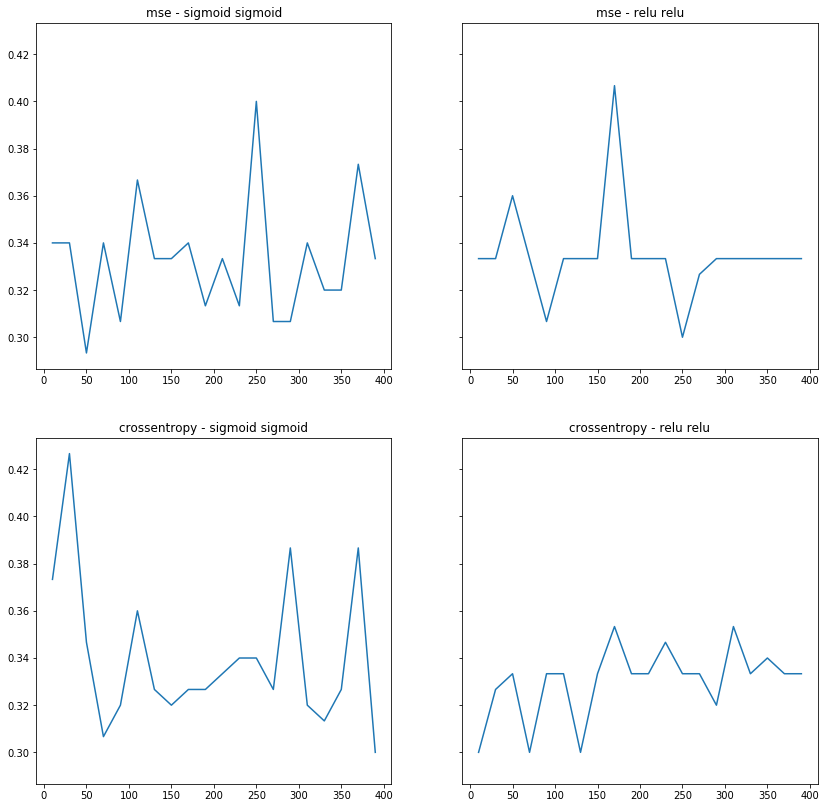

'\nplt.figure(figsize=(10, 8))\nplt.plot(epochs, results["mse"]["sigmoid_sigmoid"]["results"], label="Accuracy")\nplt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)\nplt.xlabel(\'Cantidad de epochs\')\nplt.ylabel(\'Accuracy\')\n'

In [12]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 14), sharey=True)
fig.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

axes[0, 0].plot(epochs, results["mse"]["sigmoid_sigmoid"]["results"], label="Accuracy")
axes[0, 0].set_title("mse - sigmoid sigmoid")

axes[0, 1].plot(epochs, results["mse"]["relu_relu"]["results"], label="Accuracy")
axes[0, 1].set_title("mse - relu relu")


axes[1, 0].plot(epochs, results["crossentropy"]["sigmoid_sigmoid"]["results"], label="Accuracy")
axes[1, 0].set_title("crossentropy - sigmoid sigmoid")

axes[1, 1].plot(epochs, results["crossentropy"]["relu_relu"]["results"], label="Accuracy")
axes[1, 1].set_title("crossentropy - relu relu")



plt.show()
"""
plt.figure(figsize=(10, 8))
plt.plot(epochs, results["mse"]["sigmoid_sigmoid"]["results"], label="Accuracy")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Cantidad de epochs')
plt.ylabel('Accuracy')
"""


Es fácil ver que la red neuronal no está convergiendo al aumentar el número total de epochs. Esto es debido a que los pesos no están siendo ajustados de manera correcta debido a un posible error de implementación de las ecuaciones de back propagation. Como no es imposible que exista un error en el feedforward, es posible que el error esté relacionado con la implementación de las funciones de activación, que no permiten el cálculo correcto de los pesos.

Teóricamente, los gráficos deberían aumentar su accuracy a medida que aumenta la cantidad de epochs de la red, ya que al darle más tiempo a **Gradient Descent**, este debería eventualmente converger a un mínimo local (o posibleme y deseablemente global).

##### Matriz de confusión

A continuación se presenta la matriz de confusión para **mse** con capas escondidad con función **ReLU** para la activación y con un número de **500** epochs.

In [22]:
# Entrenamos primero nuestra red neuronal
M = len(X_train[0])

network = Network([{
    "neurons": M,
    "activation": "linear",
}, {
    "neurons": 32,
    "activation": "relu"
}, {
    "neurons": 16,
    "activation": "relu"
}, {
    "neurons": 3,
    "activation": "softmax"
}], loss=loss)
network.SGD(X_train, y_onehot, 500, 0.1)

# El resultado es el siguiente
result = network.evaluate(X)

Confusion matrix, without normalization
[[50  0  0]
 [50  0  0]
 [50  0  0]]


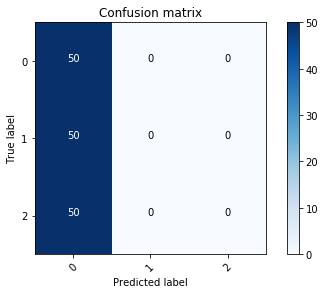

In [23]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def onehot_to_number(x):
    return np.argmax(x)


y_hat = []

for y in result:
    y_hat.append(onehot_to_number(y))
    
y_hh = []

for y in y_onehot:
    y_hh.append(onehot_to_number(y))
    
matrix = confusion_matrix(y_hh, y_hat)
plot_confusion_matrix(matrix, [0, 1, 2])

plt.show()

La matriz de confusión muestra que la red neuronal está clasificando de forma incorrecta la mayoría de los datos de entrada. Es más, está clasificando todos los outputs incorrectamente de la clase 0. Esto se relaciona directamente con los problemas detectados en el gráfico de accuracy versus epochs.